In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [3]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
train_df.dtypes[train_df.dtypes != 'object']

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

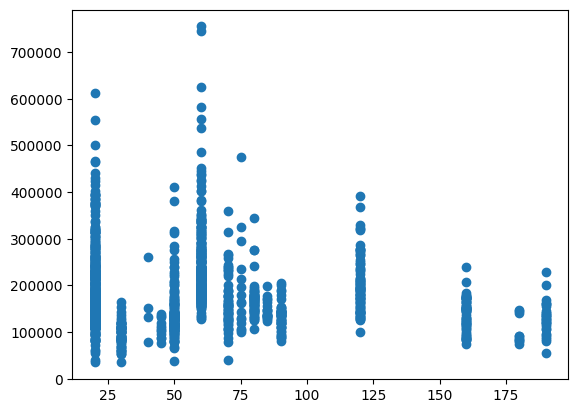

In [7]:
plt.scatter(x='MSSubClass', y='SalePrice', data=train_df)

In [8]:
train_df.query('LotFrontage > 300')

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


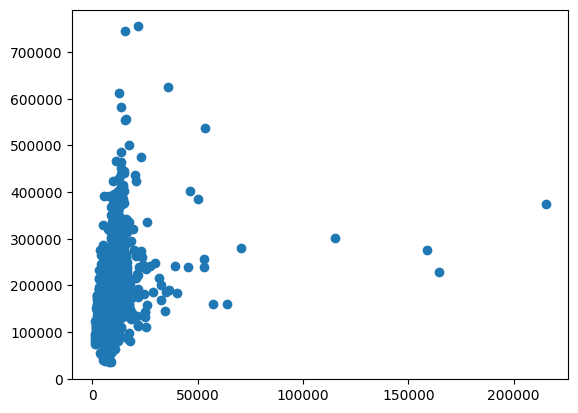

In [9]:
plt.scatter(x='LotArea', y='SalePrice', data=train_df)


In [10]:
train_df.query('LotArea > 55000')

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
451,452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1396,1397,20,RL,NaN,57200,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,160000


In [11]:
stats.zscore(train_df['LotArea']).sort_values().tail(10)

384      4.268474
457      4.280500
769      4.308262
1396     4.678682
1298     5.348867
451      6.037793
706     10.486449
249     14.881285
335     15.448542
313     20.518273
Name: LotArea, dtype: float64

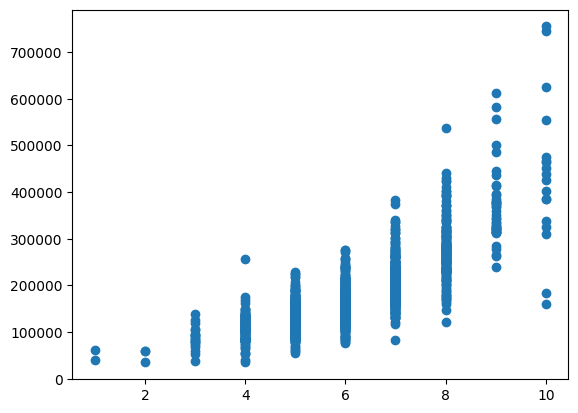

In [12]:
plt.scatter(x='OverallQual', y='SalePrice', data=train_df)

In [13]:
train_df.query('OverallQual == 10')

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
58,59,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
224,225,20,RL,103.0,13472,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,386250
389,390,60,RL,96.0,12474,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,New,Partial,426000
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
515,516,20,RL,94.0,12220,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,New,Partial,402861
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
583,584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
591,592,60,RL,97.0,13478,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,ConLI,Normal,451950
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


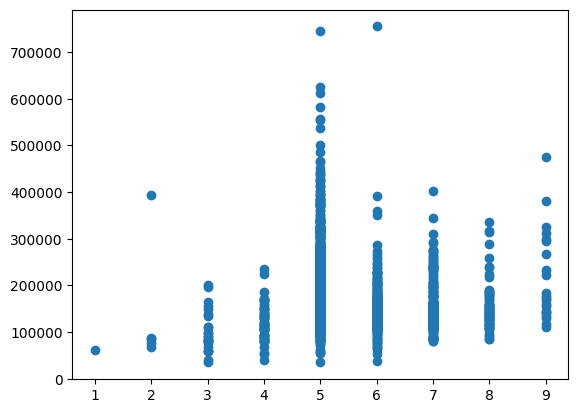

In [14]:
plt.scatter(x='OverallCond', y='SalePrice', data=train_df)

In [15]:
train_df.query('OverallCond == 2')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
88,89,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,85000
250,251,30,RL,55.0,5350,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdWo,Shed,450,5,2010,WD,Normal,76500
378,379,20,RL,88.0,11394,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,New,Partial,394432
398,399,30,RM,60.0,8967,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,WD,Abnorml,67000
676,677,70,RM,60.0,9600,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,87000


In [16]:
train_df.query('OverallCond == 5 & SalePrice > 700000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


In [17]:
train_df.query('OverallCond == 6 & SalePrice > 700000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


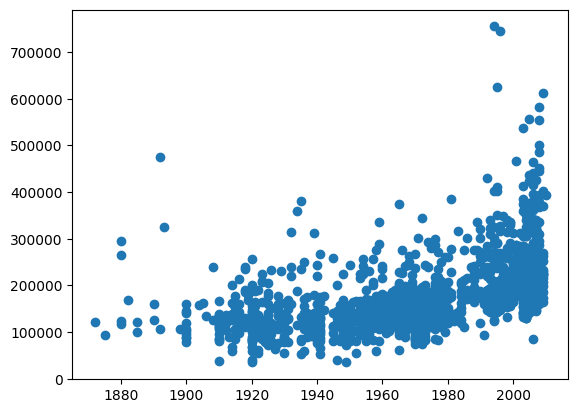

In [18]:
plt.scatter(x='YearBuilt', y='SalePrice', data=train_df)

In [19]:
train_df.query('YearBuilt < 1900 & SalePrice > 400000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


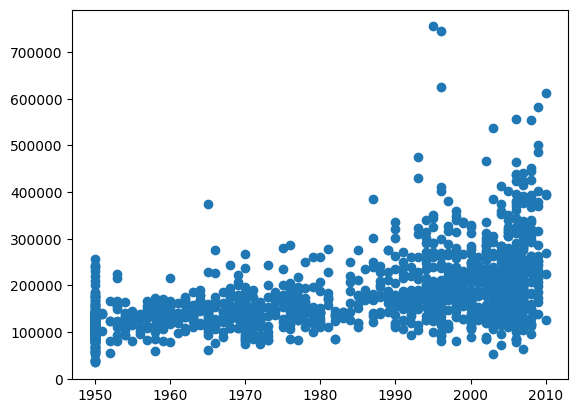

In [20]:
plt.scatter(x='YearRemodAdd', y='SalePrice', data=train_df)

In [21]:
train_df.query('YearRemodAdd < 1970 & SalePrice > 300000')


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000


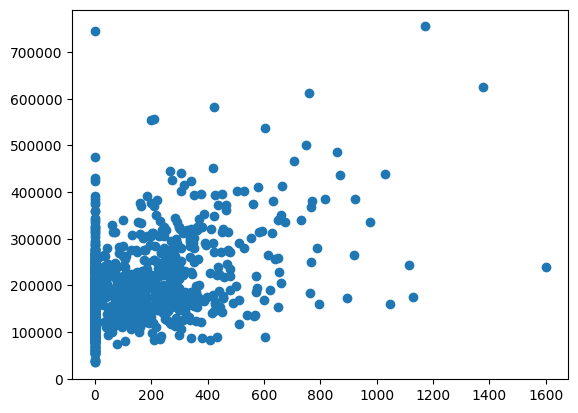

In [22]:
plt.scatter(x='MasVnrArea', y='SalePrice', data=train_df)

In [23]:
values = [598, 955, 935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 441, 186, 524, 739, 598, 955, 636, 1062, 1191, 496, 198, 1338]

In [24]:
train_df = train_df[train_df.Id.isin(values) == False]

In [25]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20)

,0
PoolQC,1435
MiscFeature,1388
Alley,1350
Fence,1162
MasVnrType,861
FireplaceQu,684
LotFrontage,255
GarageYrBlt,76
GarageCond,76
GarageType,76


In [26]:
train_df['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [27]:
train_df['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [28]:
train_df['Alley'].fillna('No', inplace=True)
test_df['Alley'].fillna('No', inplace=True)

<ipython-input-28-b441ac6b2592>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Alley'].fillna('No', inplace=True)
<ipython-input-28-b441ac6b2592>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

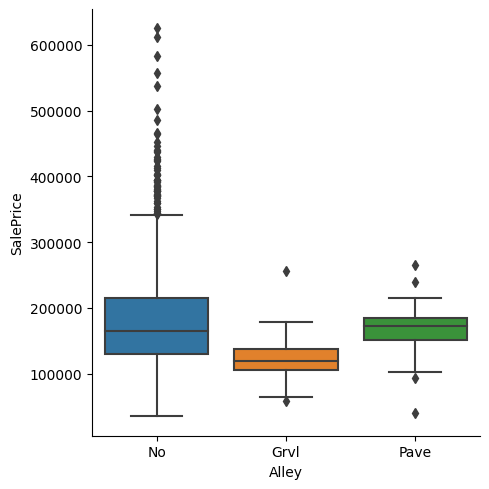

In [29]:
sns.catplot(data=train_df, x="Alley", y="SalePrice", kind="box")

In [30]:
train_df['MasVnrType'].fillna('No', inplace=True)
test_df['MasVnrType'].fillna('No', inplace=True)

<ipython-input-30-6613c27331c7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['MasVnrType'].fillna('No', inplace=True)
<ipython-input-30-6613c27331c7>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [31]:
train_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrArea'].fillna(0, inplace=True)

<ipython-input-31-75a3ef65fa78>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['MasVnrArea'].fillna(0, inplace=True)
<ipython-input-31-75a3ef65fa78>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [32]:
train_df['FireplaceQu'].fillna('No', inplace=True)
test_df['FireplaceQu'].fillna('No', inplace=True)

<ipython-input-32-e7aa724f0c3f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['FireplaceQu'].fillna('No', inplace=True)
<ipython-input-32-e7aa724f0c3f>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

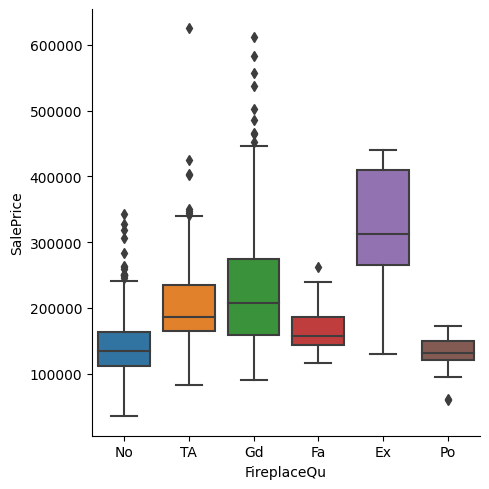

In [33]:
sns.catplot(data=train_df, x="FireplaceQu", y="SalePrice", kind="box")

In [34]:
train_df['LotFrontage'].fillna(0, inplace=True)
test_df['LotFrontage'].fillna(0, inplace=True)

<ipython-input-34-1323975fd6c0>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['LotFrontage'].fillna(0, inplace=True)
<ipython-input-34-1323975fd6c0>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [35]:
train_df['GarageYrBlt'].corr(train_df['YearBuilt'])

0.8289827595060575

In [36]:
train_df['GarageCond'].fillna('No', inplace=True)
test_df['GarageCond'].fillna('No', inplace=True)

<ipython-input-36-0e0907867bf3>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageCond'].fillna('No', inplace=True)
<ipython-input-36-0e0907867bf3>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [37]:
train_df['GarageType'].fillna('No', inplace=True)
test_df['GarageType'].fillna('No', inplace=True)

<ipython-input-37-d380e978e307>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageType'].fillna('No', inplace=True)
<ipython-input-37-d380e978e307>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [38]:
train_df['GarageFinish'].fillna('No', inplace=True)
test_df['GarageFinish'].fillna('No', inplace=True)

<ipython-input-38-727a00263db3>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageFinish'].fillna('No', inplace=True)
<ipython-input-38-727a00263db3>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [39]:
train_df['GarageQual'].fillna('No', inplace=True)
test_df['GarageQual'].fillna('No', inplace=True)

<ipython-input-39-9ffb27fb57c2>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageQual'].fillna('No', inplace=True)
<ipython-input-39-9ffb27fb57c2>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [40]:
train_df['BsmtFinType2'].fillna('Unf', inplace=True)
test_df['BsmtFinType2'].fillna('Unf', inplace=True)

<ipython-input-40-8c1b15048260>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtFinType2'].fillna('Unf', inplace=True)
<ipython-input-40-8c1b15048260>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [41]:
train_df['BsmtExposure'].fillna('No', inplace=True)
test_df['BsmtExposure'].fillna('No', inplace=True)

<ipython-input-41-e91c95f42b8f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtExposure'].fillna('No', inplace=True)
<ipython-input-41-e91c95f42b8f>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [42]:
train_df['BsmtQual'].fillna('No', inplace=True)
test_df['BsmtQual'].fillna('No', inplace=True)

<ipython-input-42-4992b8d3160d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtQual'].fillna('No', inplace=True)
<ipython-input-42-4992b8d3160d>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [43]:
train_df['BsmtCond'].fillna('No', inplace=True)
test_df['BsmtCond'].fillna('No', inplace=True)

<ipython-input-43-afb3c4a8ae04>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtCond'].fillna('No', inplace=True)
<ipython-input-43-afb3c4a8ae04>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [44]:
train_df['BsmtFinType1'].fillna('Unf', inplace=True)
test_df['BsmtFinType1'].fillna('Unf', inplace=True)

<ipython-input-44-4b70e9dc872c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtFinType1'].fillna('Unf', inplace=True)
<ipython-input-44-4b70e9dc872c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [45]:
train_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrArea'].fillna(0, inplace=True)

<ipython-input-45-75a3ef65fa78>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['MasVnrArea'].fillna(0, inplace=True)
<ipython-input-45-75a3ef65fa78>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [46]:
train_df['Electrical'].fillna('SBrkr', inplace=True)
test_df['Electrical'].fillna('SBrkr', inplace=True)

<ipython-input-46-5e2c40884455>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Electrical'].fillna('SBrkr', inplace=True)
<ipython-input-46-5e2c40884455>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [47]:
train_df = train_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
test_df = test_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])


In [48]:
train_df['houseage'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['houseage'] = test_df['YrSold'] - test_df['YearBuilt']

In [49]:
train_df['houseremodelage'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['houseremodelage'] = test_df['YrSold'] - test_df['YearRemodAdd']

In [50]:
train_df['totalsf'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
test_df['totalsf'] = test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['BsmtFinSF1'] + test_df['BsmtFinSF2']

In [51]:
train_df['totalarea'] = train_df['GrLivArea'] + train_df['TotalBsmtSF']
test_df['totalarea'] = test_df['GrLivArea'] + test_df['TotalBsmtSF']

In [52]:
train_df['totalbaths'] = train_df['BsmtFullBath'] + train_df['FullBath'] + 0.5 * (train_df['BsmtHalfBath'] + train_df['HalfBath']) 
test_df['totalbaths'] = test_df['BsmtFullBath'] + test_df['FullBath'] + 0.5 * (test_df['BsmtHalfBath'] + test_df['HalfBath']) 

In [53]:
train_df['totalporchsf'] = train_df['OpenPorchSF'] + train_df['3SsnPorch'] + train_df['EnclosedPorch'] + train_df['ScreenPorch'] + train_df['WoodDeckSF']
test_df['totalporchsf'] = test_df['OpenPorchSF'] + test_df['3SsnPorch'] + test_df['EnclosedPorch'] + test_df['ScreenPorch'] + test_df['WoodDeckSF']

In [54]:
train_df = train_df.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])
test_df = test_df.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

<Axes: >

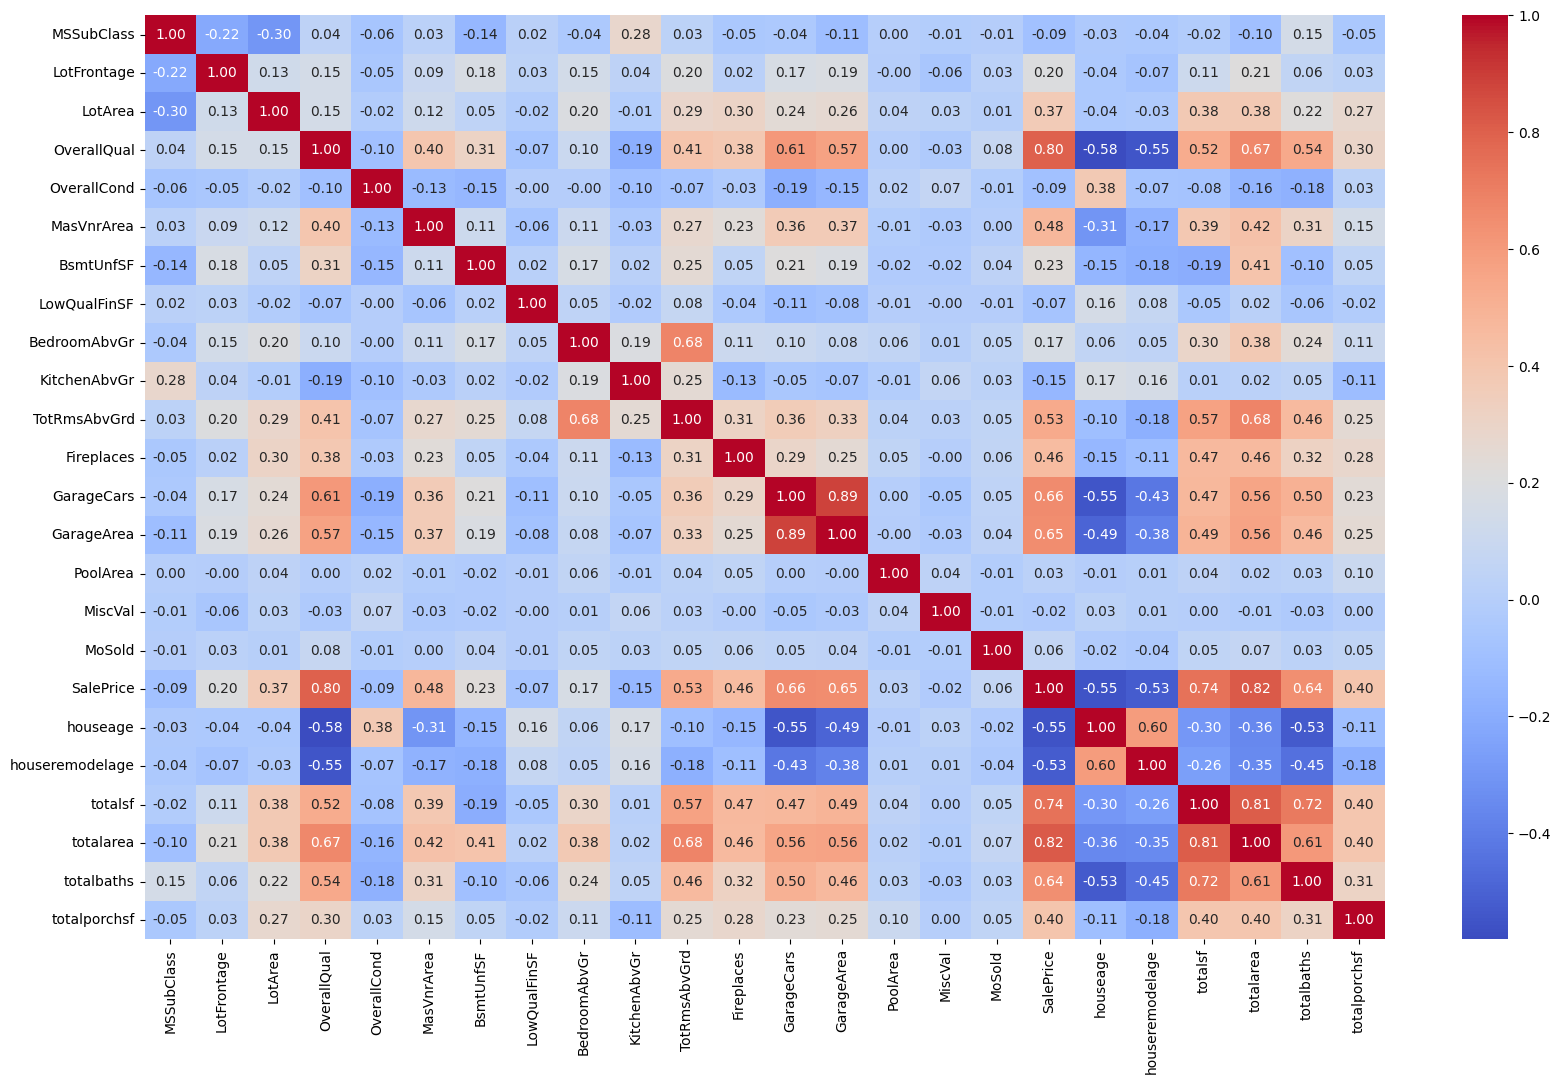

In [55]:
correlation_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [56]:
train_df = train_df.drop(columns=['GarageArea'])
test_df = test_df.drop(columns=['GarageArea'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

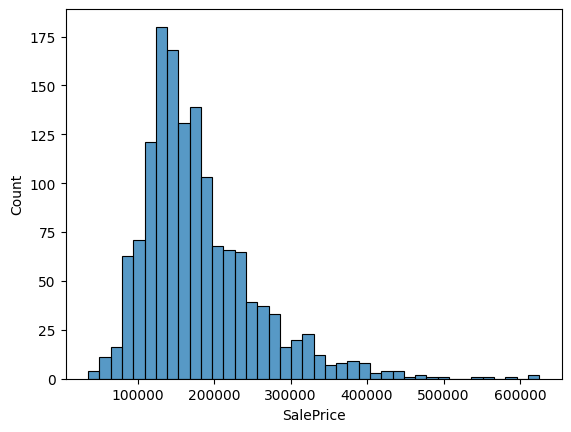

In [57]:
sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

In [58]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

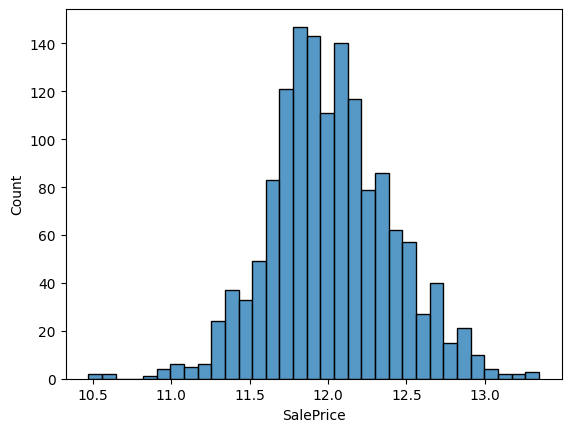

In [59]:
sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

In [60]:
ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', \
           'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']

In [61]:
ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', \
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']

In [62]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')

In [63]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [64]:
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [65]:
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [66]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [67]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [68]:
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

In [69]:
X_preprocessed = pipeline.fit_transform(X)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=25)

In [71]:
lr = LinearRegression()

In [72]:
lr.fit(X_train, y_train)

LinearRegression()

In [73]:
y_pred_lr = lr.predict(X_test)

In [74]:
mean_squared_error(y_test, y_pred_lr)

6.668901938823623e+18

In [75]:
RFR = RandomForestRegressor(random_state=13)

In [76]:
param_grid_RFR = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}

In [77]:
rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [78]:
rfr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=13), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [100, 250, 500]},
             scoring='neg_mean_squared_error')

In [79]:
np.sqrt(-1 * rfr_cv.best_score_)

0.13395680935228135

In [80]:
rfr_cv.best_params_

{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 500}

In [81]:
XGB = XGBRegressor(random_state=13)

In [82]:
param_grid_XGB = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [83]:
xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [84]:
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=13, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3],
                         'min_child_weight': [1, 2, 3], 'n_estimators': [300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [85]:
np.sqrt(-1 * xgb_cv.best_score_)

0.11933683622521173

In [86]:
ridge = Ridge()

In [87]:
param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}

In [88]:
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [89]:
ridge_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1, 1, 3, 5, 10],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag']},
             scoring='neg_mean_squared_error')

In [90]:
np.sqrt(-1 * ridge_cv.best_score_)

0.10909197852328456

In [91]:
GBR = GradientBoostingRegressor()

In [92]:
param_grid_GBR = {
    'max_depth': [12, 15, 20],
    'n_estimators': [200, 300, 1000],
    'min_samples_leaf': [10, 25, 50],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_features': [0.01, 0.1, 0.7]
}

In [93]:
GBR_cv = GridSearchCV(GBR, param_grid_GBR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [94]:
GBR_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [12, 15, 20],
                         'max_features': [0.01, 0.1, 0.7],
                         'min_samples_leaf': [10, 25, 50],
                         'n_estimators': [200, 300, 1000]},
             scoring='neg_mean_squared_error')

In [95]:
np.sqrt(-1 * GBR_cv.best_score_)

0.11369686341987816

In [96]:
lgbm_regressor = lgb.LGBMRegressor()

In [97]:
param_grid_lgbm = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

In [98]:
lgbm_cv = GridSearchCV(lgbm_regressor, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [99]:
lgbm_cv.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1994
[LightGBM] [Info] Number of data points in the train set: 1151, number of used features: 112
[LightGBM] [Info] Start training from score 12.023259


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [20, 30, 40]},
             scoring='neg_mean_squared_error')

In [100]:
np.sqrt(-1 * lgbm_cv.best_score_)

0.12728980697034

In [101]:
catboost = CatBoostRegressor(loss_function='RMSE', verbose=False)

In [102]:
param_grid_cat ={
    'iterations': [100, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

In [103]:
cat_cv = GridSearchCV(catboost, param_grid_cat, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [104]:
cat_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7955a9d6fc70>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1, 0.5]},
             scoring='neg_mean_squared_error')

In [105]:
np.sqrt(-1 * cat_cv.best_score_)

0.11495736655121701

In [106]:
vr = VotingRegressor([('gbr', GBR_cv.best_estimator_),
                      ('xgb', xgb_cv.best_estimator_),
                      ('ridge', ridge_cv.best_estimator_)],
                    weights=[2,3,1])

In [107]:
vr.fit(X_train, y_train)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(learning_rate=0.01,
                                                       max_depth=15,
                                                       max_features=0.1,
                                                       min_samples_leaf=25,
                                                       n_estimators=1000)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_m...
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None, min_child_weight=2,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=13, ...)),
                            ('ridge', Ridge(alpha=5, solver='lsqr'))],
                weights=[2, 3, 1])

In [108]:
y_pred_vr = vr.predict(X_test)

In [109]:
mean_squared_error(y_test, y_pred_vr, squared=False)

0.11827199638059875

In [110]:
estimators = [
    ('gbr', GBR_cv.best_estimator_),
    ('xgb', xgb_cv.best_estimator_),
    ('cat', cat_cv.best_estimator_),
    ('lgb', lgbm_cv.best_estimator_),
    ('rfr', rfr_cv.best_estimator_),
]

In [111]:
stackreg = StackingRegressor(
            estimators = estimators,
            final_estimator = vr
)

In [112]:
stackreg.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1994
[LightGBM] [Info] Number of data points in the train set: 1151, number of used features: 112
[LightGBM] [Info] Start training from score 12.023259
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1896
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 106
[LightGBM] [Info] Start training from score 12.032469
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

StackingRegressor(estimators=[('gbr',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=15,
                                                         max_features=0.1,
                                                         min_samples_leaf=25,
                                                         n_estimators=1000)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval...
                                                                            interaction_constraints=None,
                                                                            learning_rate=0.05,
                                                                            max_bin=None,
                                                                            max_cat_threshold=None,
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=3,
                                                                            max_leaves=None,
                                                                            min_child_weight=2,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=300,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=13, ...)),
                                                              ('ridge',
                                                               Ridge(alpha=5,
                                                                     solver='lsqr'))],
                                                  weights=[2, 3, 1]))

In [113]:
y_pred_stack = stackreg.predict(X_test)

In [114]:
mean_squared_error(y_test, y_pred_stack, squared=False)

0.11686297163801702

In [115]:
df_test_preprocess = pipeline.transform(test_df)

In [116]:
y_stacking = np.exp(stackreg.predict(df_test_preprocess))

df_y_stacking_out = test_df[['Id']]
df_y_stacking_out['SalePrice'] = y_stacking

df_y_stacking_out.to_csv('next_HousePrice_submission.csv', index=False)

<ipython-input-116-3df164da3c84>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_stacking_out['SalePrice'] = y_stacking
